In [347]:
import numpy as np
import scipy.stats as stats
import msprime
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
import pandas as pd

## Noise in Pairwise Diversity

If we care about simulating some process and learning about some parameter from the observed $T_2$s (or some function of them), we need to get sense of the noise around $\pi$ and $T_2$. According to Tajima (1983), the variance in $\pi$ is:

$$\text{Var}(\pi) = \frac{n + 1}{3(n-1)} \theta + \frac{2(n^2 + n + 3)}{9n(n-1)}\theta^2$$

In the limit as $n \to \infty$, $\text{Var} = \frac{1}{9}(3 \theta + 2 \theta^2)$. The first term is the sampling variation, the second is the evolutionary variation. 

Does this theory check out?

In [268]:
N = 1000
ns = [2, 4, 6, 10, 20, 30, 40] + np.arange(50, N, 100).tolist()

In [273]:
y = [np.var([msprime.sim_ancestry(n, population_size=N).diversity(mode='branch')/(4*N) for _ in range(1000)]) for n in ns]

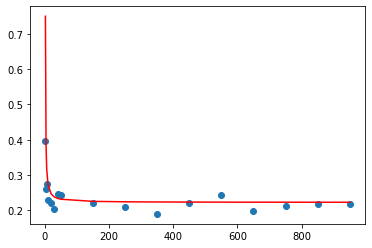

In [464]:
def taj83_var(n, theta):
    return (n+1)/(3*(n-1))*theta + 2*(n**2 + n + 3)/(9*n*(n-1)) * theta**2
plt.scatter(ns, y)
plt.plot(ns, taj83_var(np.array(ns), 1/2), c='r')

Recall, branch-mode diversity returns $T_2$ in units of 4N, e.g. if $\mu = 1$:

In [463]:
np.mean([msprime.sim_ancestry(100, population_size=1000).diversity(mode='branch')/(4*1000) for _ in range(1000)])

1.026909460669142

## Estimating B

If we're using branch statistics, our only source of variation is evolutionary variation. The pairwise coalescent time $T_2 \sim \text{Exp}(1/2N)$, such that $\text{E}(T_2) = 2N$ and $\text{Var}(T_2) = 4N^2$.

We imagine some fixed scalar $B$ rescales $N$; we wish to estimate this from $s$ observed trees using $\bar{B} = 1/s \sum_i^s T_2(i)/2N$. $\mathrm{E}(\bar{B}) = 2BN/2N = B$ so this is an unbiased estimator of $B$. $\mathrm{Var}(\bar{B}) = \frac{s \mathrm{Var}(T_2)}{4 s^2 N^2}  = \frac{4B^2N^2s}{4 s^2 N^2} = B^2/s$.

**Importantly**, note that this *ignores* the process noise due to selection; in reality $B$ itself is a random variable. However, selection may decrease $\mathrm{Var}(T_2)$.

Below I simulate this: each run draws $s$ sample trees, calculates $\hat{B}$ for each tree, and average them to get $\bar{B}$. I then consider the variance of these $\bar{B}$s.

In [297]:
N = 1000
B_array = np.linspace(0.1, 1, 10)
s_array = [2, 5, 10, 50, 100]
n_array = [N]
N_array = [N]
rep_array = np.arange(1000)
params = list(itertools.product(B_array, s_array, n_array, N_array, rep_array))
param_grid = np.array(params)

def runner(param):
    B, s, n, N, rep = param
    sims = np.array([msprime.sim_ancestry(n, population_size=B*N).diversity(mode='branch')/(4*N) for _ in range(s)])
    return sims.mean(), sims.var()

with Pool(70) as p:
    res = np.array(p.map(runner, params))

In [377]:
d = pd.DataFrame(np.concatenate((param_grid, res[:, 0][:, None]), axis=1))
d.columns = ['B', 's', 'n', 'N', 'rep', 'Bhat']
d.head()

,B,s,n,N,rep,Bhat
0,0.1,2.0,1000.0,1000.0,0.0,0.059737
1,0.1,2.0,1000.0,1000.0,1.0,0.064928
2,0.1,2.0,1000.0,1000.0,2.0,0.108950
3,0.1,2.0,1000.0,1000.0,3.0,0.076978
4,0.1,2.0,1000.0,1000.0,4.0,0.096129


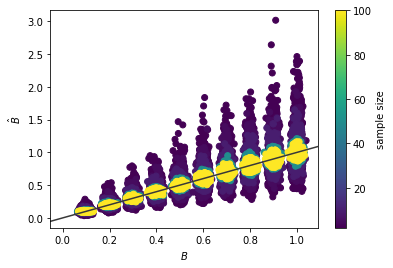

In [455]:
def jitter(x, var=0.01):
    return x + np.random.normal(0, var, len(x))

fig, ax = plt.subplots()
cax = ax.scatter(jitter(d['B']), d['Bhat'], c=d['s'], alpha=1)
ax.axline((0, 0), slope=1, c='0.22')
ax.set_xlabel('$B$')
ax.set_ylabel('$\hat{B}$')
plt.colorbar(cax, label='sample size')

In [395]:
ds = d.groupby(['B', 's', 'n', 'N']).agg([np.mean, np.var]).reset_index()
ds.columns = ["_".join(x) if len(x[1]) > 0 else x[0] for x in ds.columns]
ds.head()

,B,s,n,N,rep_mean,rep_var,Bhat_mean,Bhat_var
0,0.1,2.0,1000.0,1000.0,499.5,83416.666667,0.100114,0.001105
1,0.1,5.0,1000.0,1000.0,499.5,83416.666667,0.099060,0.000447
2,0.1,10.0,1000.0,1000.0,499.5,83416.666667,0.100330,0.000226
3,0.1,50.0,1000.0,1000.0,499.5,83416.666667,0.100451,0.000047
4,0.1,100.0,1000.0,1000.0,499.5,83416.666667,0.099921,0.000021


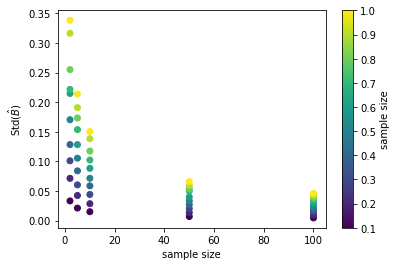

In [451]:
fig, ax = plt.subplots()
cax = ax.scatter(ds['s'], np.sqrt(ds['Bhat_var']), c=ds['B'])
ax.set_ylabel("$\mathrm{Std}(\hat{B})$")
ax.set_xlabel("sample size")
plt.colorbar(cax, label='sample size')

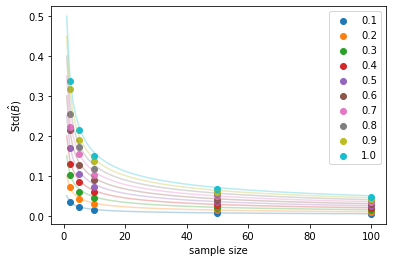

In [ ]:
fig, ax = plt.subplots()
sx = np.arange(1, 100)
for b in B_array:
    dx = ds.loc[ds['B'] == b]
    c = ax.scatter(dx['s'], np.sqrt(dx['Bhat_var']), label=np.round(b, 2))
    ax.plot(sx, b*np.sqrt(0.25/sx), alpha=0.3)
ax.set_ylabel("$\mathrm{Std}(\hat{B})$")
ax.set_xlabel("sample size")
ax.legend()

Note that our theory works well, even though we're not conditioning on genealogies, but just imagining averaging over independent coalescent pairs to get $T_2$. This is because as the first section showed, the vast majority of the noise is from the evolutionary process itself.

## Learning B

In [551]:
mu_array = 1000 * 10**np.linspace(-3, -2, 10)
s_arrray = 10**np.linspace(-6, -3, 10)
N_array = [100, 1000]
nreps_array = [100]

In [552]:
bgs_params = list(itertools.product(mu_array, s_array, N_array, nreps_array))
bgs_param_grid = np.array(bgs_params)

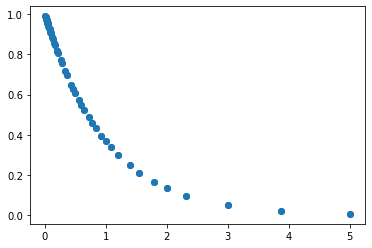

In [553]:
plt.scatter(bgs_param_grid[:, 0]/bgs_param_grid[:, 1], np.exp(-bgs_param_grid[:, 0]/bgs_param_grid[:, 1]))

In [554]:
def bgs_runner(param):
    mu, s, N, nreps = param
    B = np.exp(-mu/s)
    Bhats = np.array([msprime.sim_ancestry(N, population_size=B*N).diversity(mode='branch')/(4*N) for _ in range(nreps)])
    return Bhats.mean()

with Pool(70) as p:
    res = np.array(p.map(bgs_runner, bgs_params))

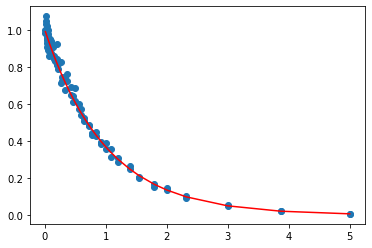

In [555]:
fig, ax = plt.subplots()
ax.scatter(bgs_param_grid[:, 0]/bgs_param_grid[:, 1], res)
rate = np.sort(bgs_param_grid[:, 0]/bgs_param_grid[:, 1])
ax.plot(rate, np.exp(-rate), c='r')
#ax.set_yscale('log')

In [ ]:
plt.scatter(bgs_param_grid[:, 0]/bgs_param_grid[:, 1], res)
rate = np.sort(bgs_param_grid[:, 0]/bgs_param_grid[:, 1])
plt.plot(rate, np.exp(-rate), c='r')

## BGS with Recombination

Note the mutation rates here are somewhat realistic, but still too high for the deleterious mutation rate. The analytic BGS function predicts small local reductions in $B$, but in terms of existing inference approaches, these only become sizeable in aggregate. Thus learning a local B function is extremely hard, as:

1. Noise is highest when $B$ is largest. 
2. Changes in $B$ are very small when looking at local features.
3. A learned function $\tilde{B}$ that's noisy is potentially bad, as $B$ is *multiplicative* across segments under purifying selection.

In [667]:
mu_array = np.linspace(1e-8, 1e-7, 10)
s_arrray = np.linspace(1e-5, 1e-1, 10)
#r_arrray = 10**np.linspace(-6, -2, 10)
r_arrray = [1e-8]
N_array = [1000]
L_arrray = [10_000, 100_000, 1_000_000]
nreps_array = [5]

In [668]:
bgs_rec_params = list(itertools.product(mu_array, s_array, r_arrray, N_array, L_arrray, nreps_array))
bgs_rec_param_grid = np.array(bgs_rec_params)

In [669]:
def bgs_rec(mu, s, r, L):
    return np.exp(-L * mu/(s*(1+(1-s)*r/s)**2))

def bgs_rec_runner(param):
    mu, s, r, N, L, nreps = param
    B = bgs_rec(mu, s, r, L)
    Bhats = np.array([msprime.sim_ancestry(N, population_size=B*N).diversity(mode='branch')/(4*N) 
                      for _ in range(nreps)])
    return Bhats.mean()

with Pool(70) as p:
    bgs_rec_res = np.array(p.map(bgs_rec_runner, bgs_rec_params))

In [676]:
np.mean([msprime.sim_ancestry(100, population_size=1000, ploidy=1).diversity(mode='branch') 
                      for _ in range(1000)])

1994.080124389312

Text(0.5, 0, '$L \\mu / s$')

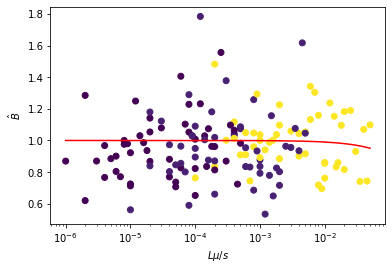

In [670]:
fig, ax = plt.subplots()
ax.scatter(bgs_rec_param_grid[:, 4]*bgs_rec_param_grid[:, 0]/bgs_rec_param_grid[:, 1], bgs_rec_res, c=bgs_rec_param_grid[:, 4])
rate = bgs_rec_param_grid[:, 4]*bgs_rec_param_grid[:, 0]/bgs_rec_param_grid[:, 1]
idx = np.argsort(rate)
y = bgs_rec(bgs_rec_param_grid[:, 0], bgs_rec_param_grid[:, 1], bgs_rec_param_grid[:, 2], bgs_rec_param_grid[:, 4])
ax.plot(rate[idx], y[idx], c='r')
ax.set_xscale('log')
ax.set_ylabel('$\hat{B}$')
ax.set_xlabel('$L \mu / s$')

In [666]:
np.prod(bgs_rec(1e-8, 1e-2, 1e-2, 1000)**1000)

0.7768415492061416